# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *
import pickle
import hls4ml


2022-06-03 10:26:08.845643: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-03 10:26:08.851184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 10:26:08.851198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


In [3]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()

2022-06-03 10:26:13.840916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 10:26:13.840955: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 10:26:13.840983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-03 10:26:13.841968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [4]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 100 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 3

def units(j): return (j+8)
units_range = 1

In [5]:
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+3)*2

def bit_width(i): return {'bits': (i+3)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 5

In [6]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta}_v{version(v)}.h5"           #optimized model = model_decay<class 'keras.regularizers.L2'>=1e-07_v0

#path of the tested models 
def hist_path(v) : return f"tests/hist/models_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta}_v{version(v)}.h5"     

#path of the qconverted models
def qmodels_path(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest9,refbm.h5"

#path of the qconverted models
def qhist_path(i): return f"tests/qhist/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest9,refbm.pkl"

#path of the qtrained models
def qtrained_models_path(j, i, v ): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_patiencES={patience_es}_patienceRLR={patience_rlr}_delta={delta}_cp,<{bit_lenghts(i)},{integer}>v{version(v)}.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

## Data creation 

In [7]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

X, X_valid, X_test, y, y_valid, y_test = ds(seq_len=30)

X_past = X[:,:25,:]
X_valid_past = X_valid[:,:25,:]
X_test_past = X_test[:,:25,:]

X = X[:,25:,:]
X_valid = X_valid[:,25:,:]
X_test = X_test[:,25:,:]

shapes (1999970, 30, 1) (1999970, 1)
shapes (899956, 30, 1) (99969, 30, 1) (999985, 30, 1)


## Training classic model


In [8]:
def normal_model (units_parameter):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        print("testing new weights")
        inputs_seq = keras.Input(shape=(5,1))
        inputs_past = keras.Input(shape=(25,))

        x = keras.layers.Dense(1, activation="relu")(inputs_past)
        x = keras.layers.Reshape((1,1))(x)

        x =keras.layers.Concatenate(axis=1)([x, inputs_seq])
        x = SimpleRNN(units_parameter, activation='relu')(x)
        outputs = Dense(1, activation='relu')(x)

        r_model = keras.Model(inputs=[inputs_past, inputs_seq], outputs=outputs, name="past_data_model_1")

        r_model.compile(loss='mse', optimizer='adam')

        history = r_model.fit([X_past, X],y,validation_data=([X_valid_past, X_valid],y_valid), epochs=1, batch_size=64, shuffle=True, callbacks=[early_stopping, reduce_lr])
        val_loss = history.history['val_loss'][0]


    r_model.summary()

    hist = r_model.fit([X_past, X],y,validation_data=([X_valid_past, X_valid],y_valid), epochs=100, batch_size=64, shuffle=True, callbacks=[early_stopping, reduce_lr])
    lr_change = []
    
    for i in range (len(hist.history['lr'])-1):
    
        if (hist.history['lr'][i]==hist.history['lr'][i+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist.history['val_loss'][i])
    plt.plot(lr_change, 'X')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(models_path(101))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'], loc='upper left')
    plt.show()
    return r_model, hist

def model_training (): 
    models =[]

    for j in range(units_range):
        units_parameter = units(j)
        for v in range(versions_range):

            if (os.path.exists(models_path(v))==False):
                model = normal_model(units_parameter)
                models.append(model[0])
                with open(hist_path(v), 'wb') as file_pi:
                    pickle.dump(model[1].history, file_pi)
                model[0].save(models_path(v))
                print('number of units ', units_parameter)  
            else : print(f'{models_path(v)} already exists')       
    return models

models = model_training()

testing new weights
14062/14062 [==============================] - 46s 3ms/step - loss: 1.7770e-05 - val_loss: 1.3582e-05 - lr: 0.0010
Model: "past_data_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 1)            26          ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1)         0           ['dense[0][0]']                  
                                                                                                  
 input_1 (InputLayer)           [(None, 5, 1)]

# 2. Quantizing it 

## Quantization conversion

In [8]:
rest_bit_width =  {'bits':  9, 'integer': integer, 'symmetric': 0, 'alpha':1}
def quantized_conv_model (bits, units_parameter, model_to_convert):  
    
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience= patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**rest_bit_width),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**rest_bit_width)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='relu',
                        kernel_quantizer=quantized_bits(**rest_bit_width),
                        bias_quantizer=quantized_bits(**rest_bit_width) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()

    #using the weight from the classic network as a base
    qr_model.set_weights(model_to_convert.get_weights())
    hist = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_conv_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])
    lr_change = []
    for i in range (len(hist.history['lr'])-1):
    
        if (hist.history['lr'][i]==hist.history['lr'][i+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist.history['val_loss'][i+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(qmodels_path(101))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()
    return qr_model, hist

def qmodel_conv_training (): 

    qmodels =[]
    qhist = []
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            if (os.path.exists(qmodels_path(i))==False):
                qmodel = quantized_conv_model(bits_parameter, units(j), boosted_model)
                qmodel[0].save(qmodels_path(i))
                with open(qhist_path(i), 'wb') as file_pi:
                    pickle.dump(qmodel[1].history, file_pi)                
                qmodels.append(qmodel[0])
                qhist.append(qmodel[1])
            else : print(f'{qmodels_path(i)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_conv_training()

tests/qmodels/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<6,0>,rest9,refbm.h5 already exists
bit width  {'bits': 6, 'integer': 0, 'symmetric': 0, 'alpha': 1}
tests/qmodels/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<8,0>,rest9,refbm.h5 already exists
bit width  {'bits': 8, 'integer': 0, 'symmetric': 0, 'alpha': 1}
tests/qmodels/qmodels_patiencES=12_patienceRLR=3_mindelta1e-08,rkernel<10,0>,rest9,refbm.h5 already exists
bit width  {'bits': 10, 'integer': 0, 'symmetric': 0, 'alpha': 1}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn (QSimpleRNN)   (None, 8)                 80        
                                                                 
 q_dense (QDense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_______

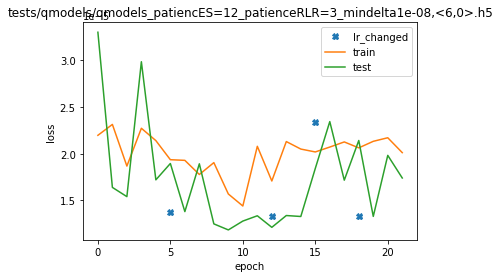

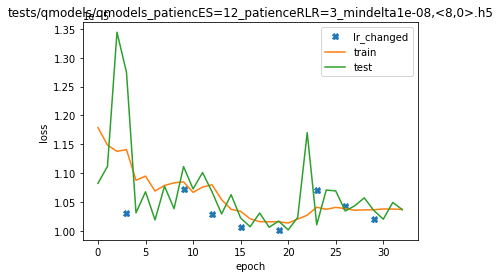

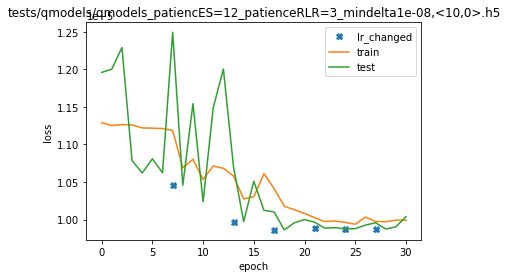

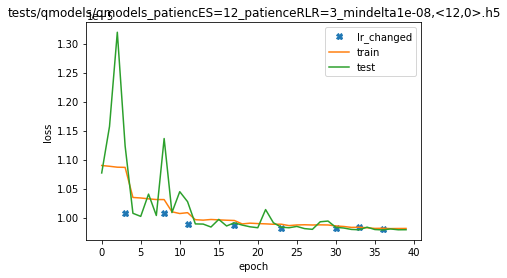

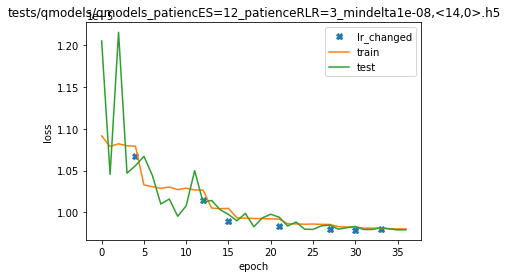

In [ ]:
for i in range (bits_range):
    file_to_read = open(qhist_path(i), "rb")

    hist = pickle.load(file_to_read)
    lr_change = []
    for k in range (len(hist['lr'])-1):

        if (hist['lr'][k]==hist['lr'][k+1]):
            lr_change.append(None)
        else:
            lr_change.append(hist['val_loss'][k+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(qmodels_path(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()

31250/31250 [==============================] - 32s 1ms/step


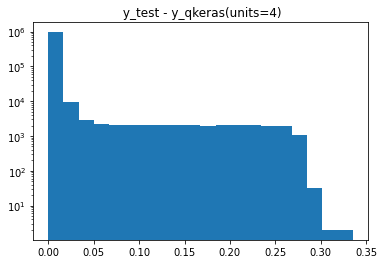

31250/31250 [==============================] - 32s 1ms/step


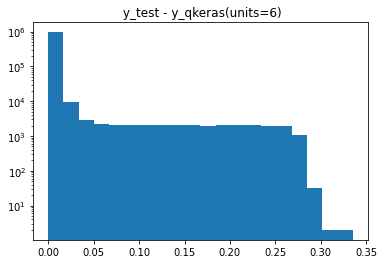

31250/31250 [==============================] - 33s 1ms/step


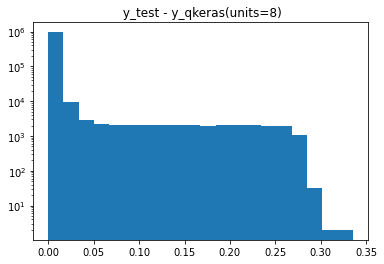

31250/31250 [==============================] - 33s 1ms/step


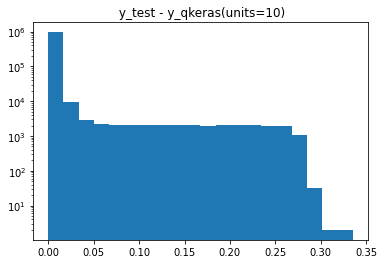

31250/31250 [==============================] - 32s 1ms/step


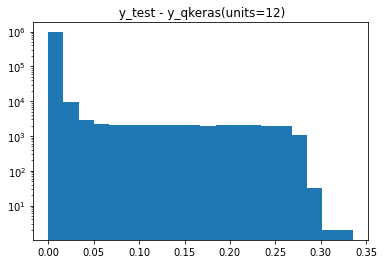

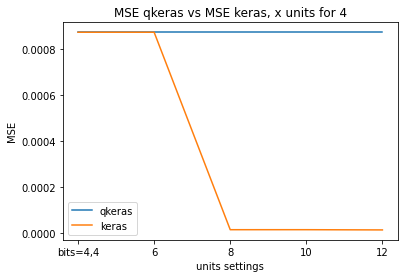

31250/31250 [==============================] - 34s 1ms/step


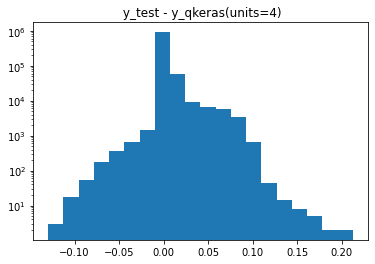

31250/31250 [==============================] - 33s 1ms/step


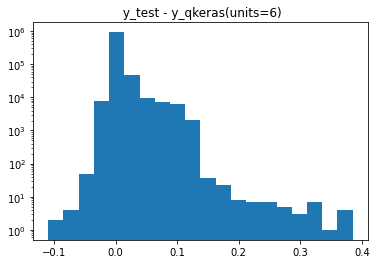

31250/31250 [==============================] - 33s 1ms/step


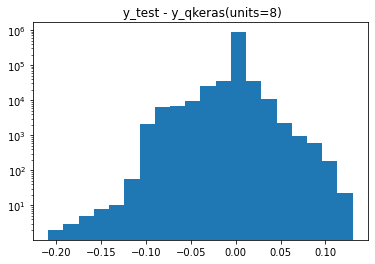

31250/31250 [==============================] - 34s 1ms/step


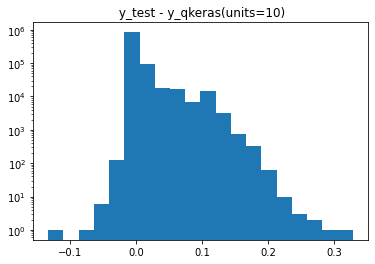

31250/31250 [==============================] - 32s 1ms/step


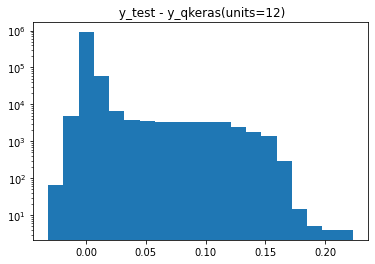

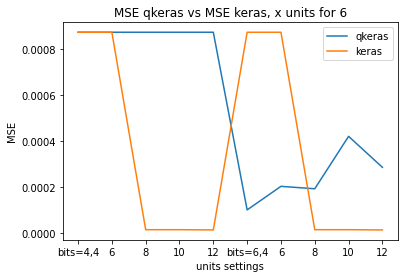

31250/31250 [==============================] - 34s 1ms/step


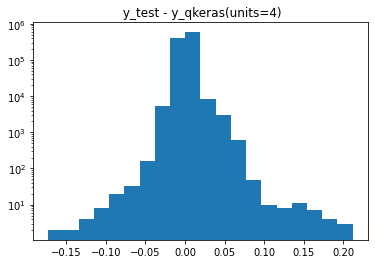

31250/31250 [==============================] - 34s 1ms/step


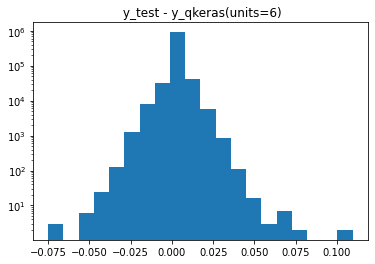

31250/31250 [==============================] - 35s 1ms/step


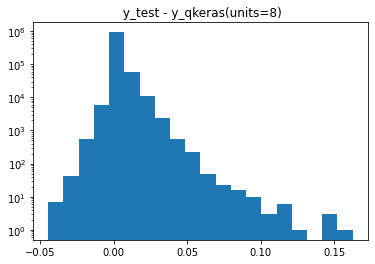

31250/31250 [==============================] - 34s 1ms/step


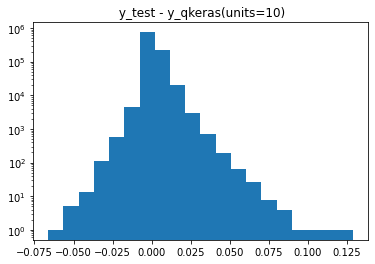

31250/31250 [==============================] - 34s 1ms/step


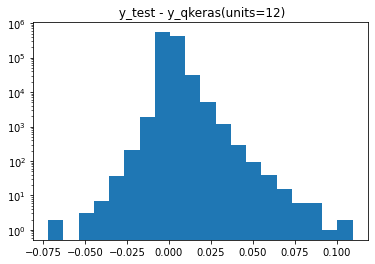

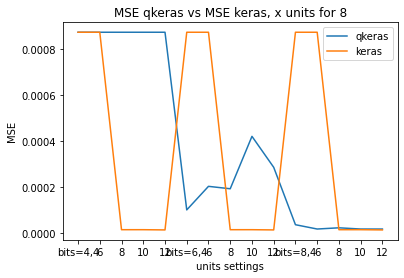

31250/31250 [==============================] - 35s 1ms/step


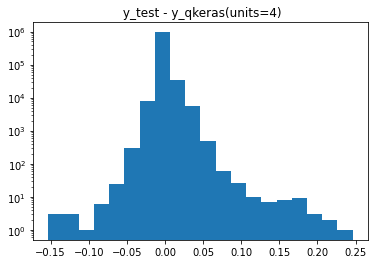

31250/31250 [==============================] - 38s 1ms/step


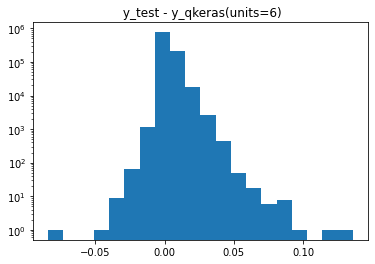

31250/31250 [==============================] - 33s 1ms/step


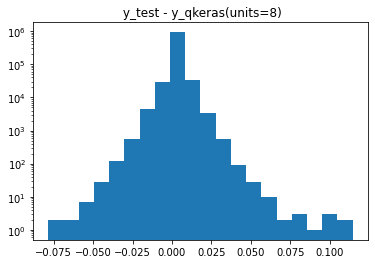

31250/31250 [==============================] - 34s 1ms/step


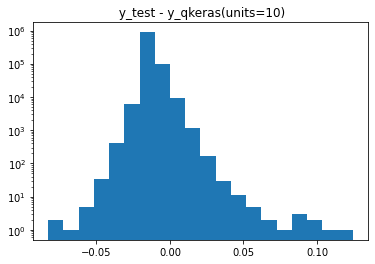

31250/31250 [==============================] - 33s 1ms/step


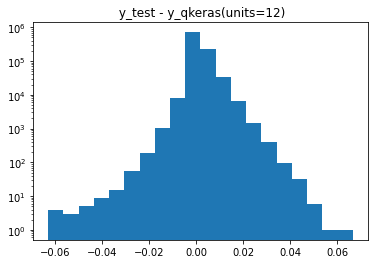

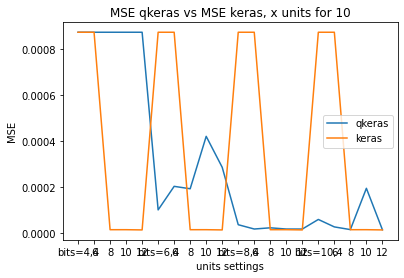

31250/31250 [==============================] - 36s 1ms/step


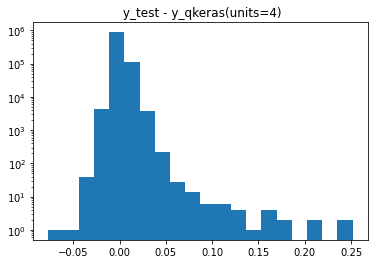

31250/31250 [==============================] - 33s 1ms/step


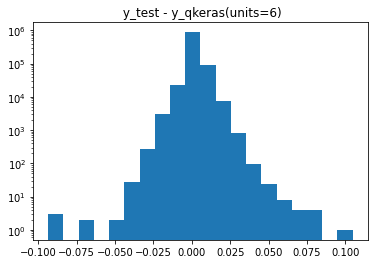

31250/31250 [==============================] - 37s 1ms/step


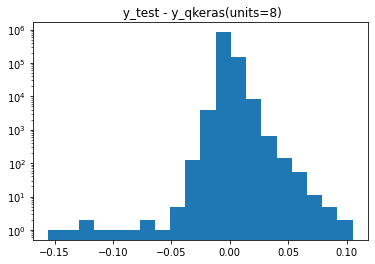

31250/31250 [==============================] - 34s 1ms/step


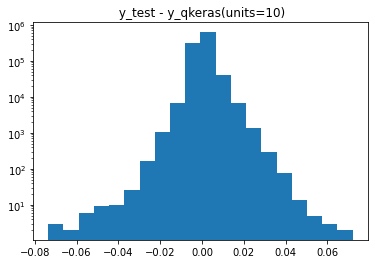

31250/31250 [==============================] - 36s 1ms/step


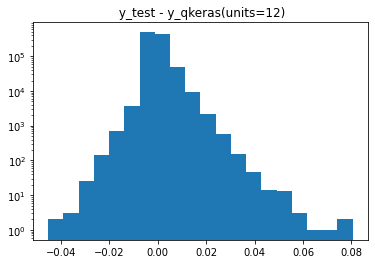

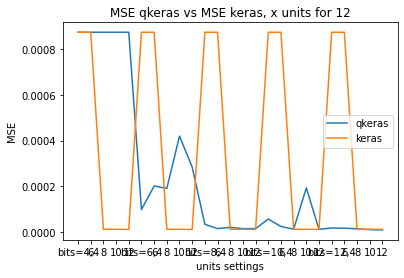

In [10]:
bit_nbr = []
loss1 = [] 
loss2 = []
unit_nbr = []

for i in range(bits_range):

    bit_nbr.append(bit_lenghts(i))
    for j in range (units_range):
        if (j==0):
            unit_nbr.append(f'bits={bit_lenghts(i)},{units(j)}')
        else: 
            unit_nbr.append(f'{units(j)}')
        qmodel = qkeras.utils.load_qmodel(qmodels_path(j,i))        
        y_qkeras = qmodel.predict(x_test)
        model = tf.keras.models.load_model(models_path(j))
        y_keras = model.predict(x_test)

        loss1.append(mse(y_test,y_qkeras))        
        loss2.append(mse(y_test,y_keras))

        plt.figure()
        plt.hist(y_test-y_qkeras, bins=20)
        plt.yscale('log')
        plt.title(f' y_test - y_qkeras(units={units(j)})')
        plt.show()
        
    plt.figure()
    plt.plot(loss1)
    plt.plot(loss2)
    plt.legend(['qkeras','keras'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    plt.xlabel('units settings')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras vs MSE keras, x units for {bit_lenghts(i)}')
    plt.show()

## Quantization training 

14063/14063 [==============================] - 35s 2ms/step - loss: 3.1208e-05 - val_loss: 1.5172e-05 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_6 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_6 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5441e-05 - val_loss: 1.4837e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.4614e-05 - val_loss: 1.4448e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.421

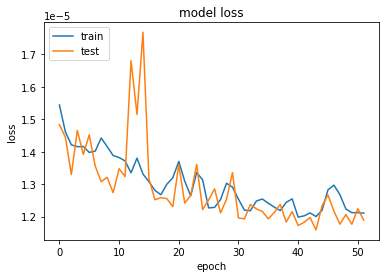

14063/14063 [==============================] - 36s 2ms/step - loss: 2.2067e-05 - val_loss: 1.7598e-05 - lr: 0.0010
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_8 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_8 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 34s 2ms/step - loss: 1.5795e-05 - val_loss: 1.5051e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5187e-05 - val_loss: 1.5081e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 31s 2ms/step - loss: 1.495

In [10]:
def quantized_model (bits, units_parameter,):  
    losses = []
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        qr_model = Sequential()
        qr_model.add(QSimpleRNN(units_parameter,
                            input_dim= 1,
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            recurrent_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits)    
                            )) 
        qr_model.add(QDense(output, 
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits) ))
        qr_model.compile(loss="mse", optimizer=Adam(lr))
        history = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = 1, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])

        val_loss = history.history['val_loss'][0]

        
    qr_model.summary()

    hist = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs =nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return qr_model

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            for v in range(versions_range):
                if (os.path.exists(qtrained_models_path(j,i,v))==False):
                    units_parameter = units(j)
                    qmodel = quantized_model(bits_parameter, units_parameter)
                    qmodel.save(qtrained_models_path(j,i,v))
                    qmodels.append(qmodel)
                else : print(f'{qtrained_models_path(j,i,v)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        